## 루브릭기준

1. SRGAN을 이용해 고해상도의 이미지를 생성하였다.

- SRGAN을 통해 생성된 이미지를 제출하였다.

2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.

- 이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.


3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.

- 저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.

## SRGAN 활용하기

### 프로젝트 1: 직접 고른 이미지로 SRGAN실험

- 프로젝트 1-1

- 프로젝트 1-2

### 프로젝트 2: SRGAN을 이용해 고해상도 gif생성

- gif파일 불러오기

- 프레임별 Super Resolution 진행하기

- 프레임합쳐서 gif 만들기

- jupyter notebook에 gif 표시하기


### 프로젝트 1-1.

1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.


2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.


3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.

5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.


6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image

890880


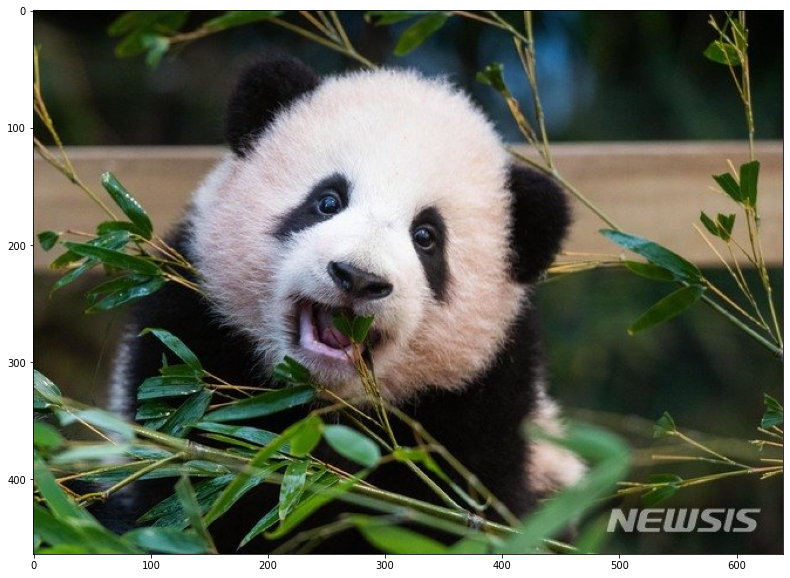

In [2]:
# 아기 판다입니다.
image_path = cv2.imread(os.getenv('HOME')+'/aiffel/super_resolution/panda.jpg')
hr_img = cv2.cvtColor(image_path, cv2.COLOR_BGR2RGB)

print(hr_img.size)
plt.figure(figsize=(30,10))
plt.imshow(hr_img)

(116, 160, 3)


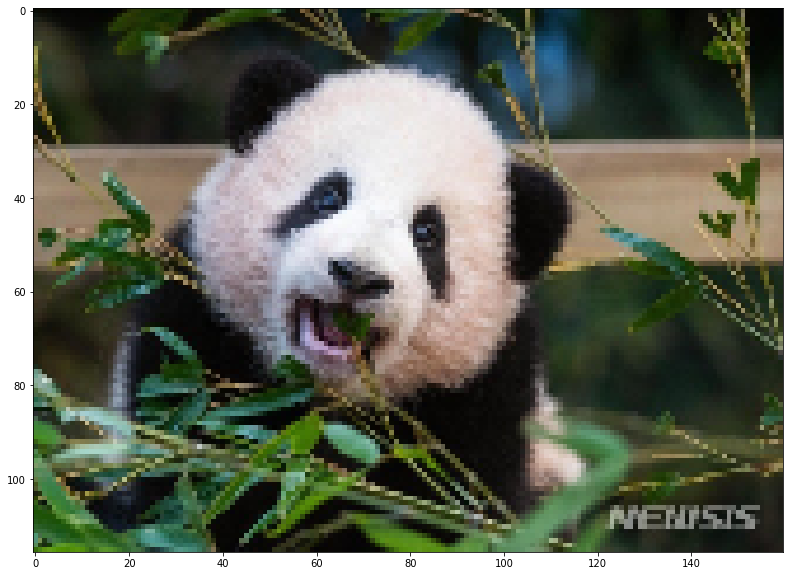

In [3]:
# 이미지 사이즈를 cv2.resize()를 사용해서 1/4 줄여서 해상도를 낮춰보겠습니다!!
lr_img = cv2.resize(
    hr_img,
    dsize=(hr_img.shape[1]//4, hr_img.shape[0]//4)
)

print(lr_img.shape)

plt.figure(figsize=(15,10))
plt.imshow(lr_img)

## SRGAN학습(고해상도 이미지 생성)

- srgan_G.h5파일은 학습 완료된 Generator

- 테스트 할 때는 고해상도 이미지 출력하는 Generator만 이용

In [4]:
# pre-trained 모델 로드
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
# 저해상도 이미지를 입력받아 SRCNN으로 고해상도 이미지를 생성하는 함수
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)# tf.clip_by_value :텐서 값을 지정된 최소 및 최대로 자릅니다.
    sr = tf.round(sr) # 텐서의 값을 요소별로 가장 가까운 정수로 반올림
    sr = tf.cast(sr, tf.uint8) # tf.cast : 텐서를 새로운 형태로 캐스팅하는데 사용
    return np.array(sr)[0]

srgan_hr = apply_srgan(lr_img)

In [6]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_img, 
    dsize=(hr_img.shape[1], hr_img.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

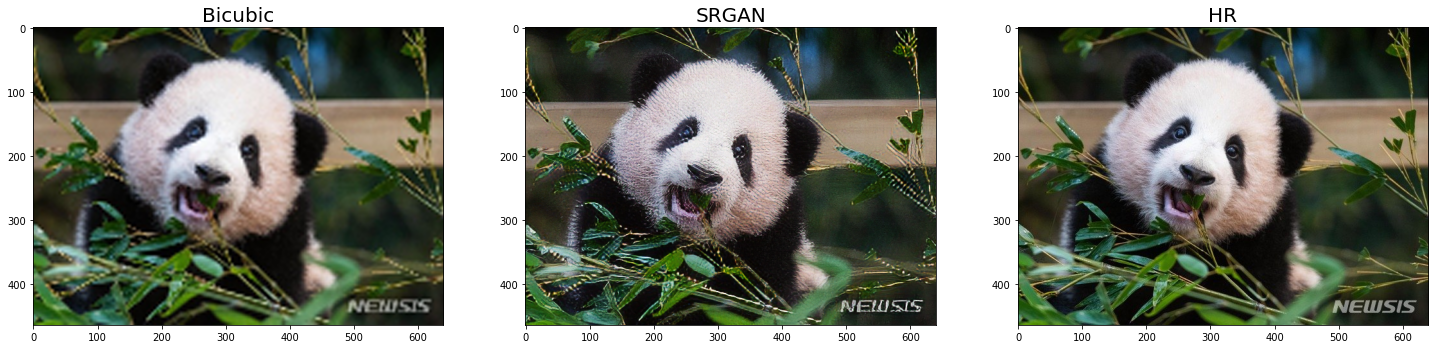

In [7]:
# 시각화
images = [bicubic_hr, srgan_hr, hr_img]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(25,15))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

In [8]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

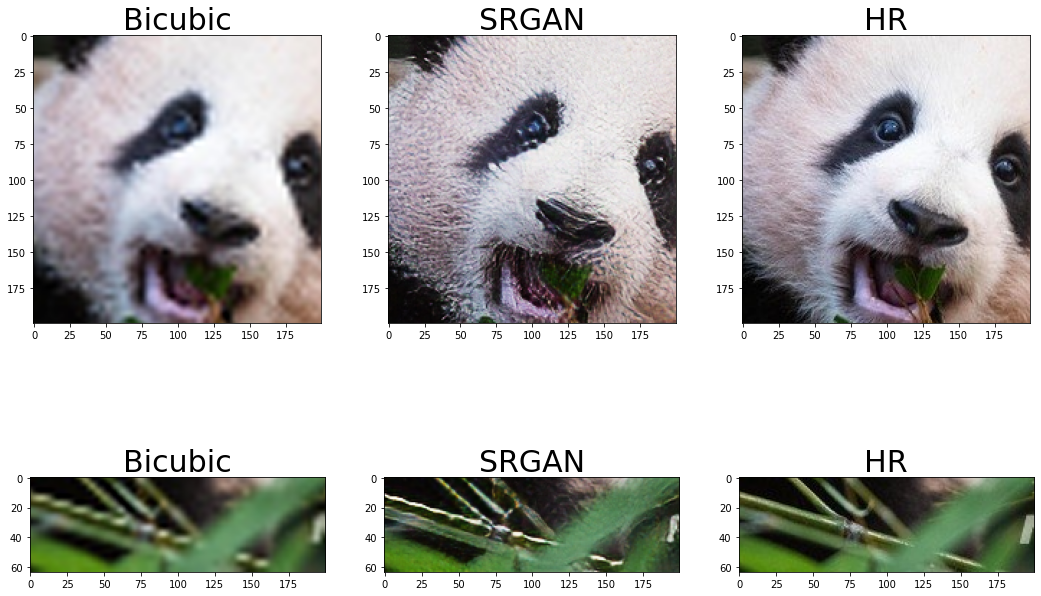

In [9]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 2개 입니다.
left_tops = [(100,150),(400,300)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr_img, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(6):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

## 결과

- bicubic interpolation을 적용한 것은 예상대로 흐리게 나왔다.

- srgan이미지는 선명도가 괜찮고 질감도 있어보인다

- HR이미지는 선명함이 독보인다

## 프로젝트 1-2

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.


2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.



3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.



4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.



5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

(224, 224, 3)


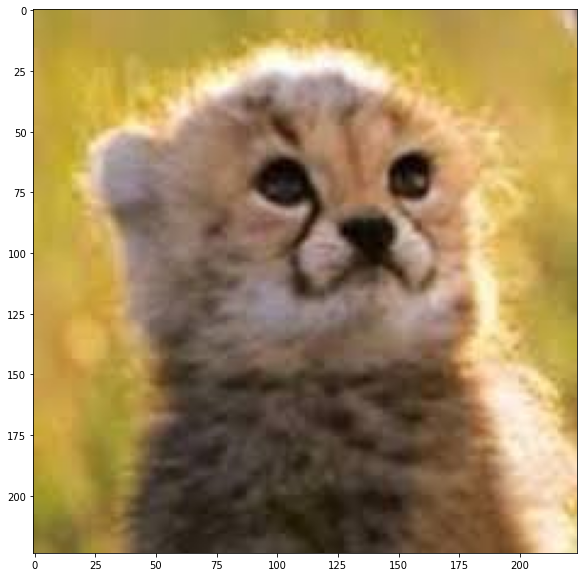

In [10]:
# 저해상도 이미지 불러오기
image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/mark.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)

plt.figure(figsize=(30,10))
plt.imshow(image)

In [11]:
# SRGAN으로 고해상도 이미지 생성
srgan_hr = apply_srgan(image)

In [12]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    image, 
    dsize=(image.shape[1]*4, image.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

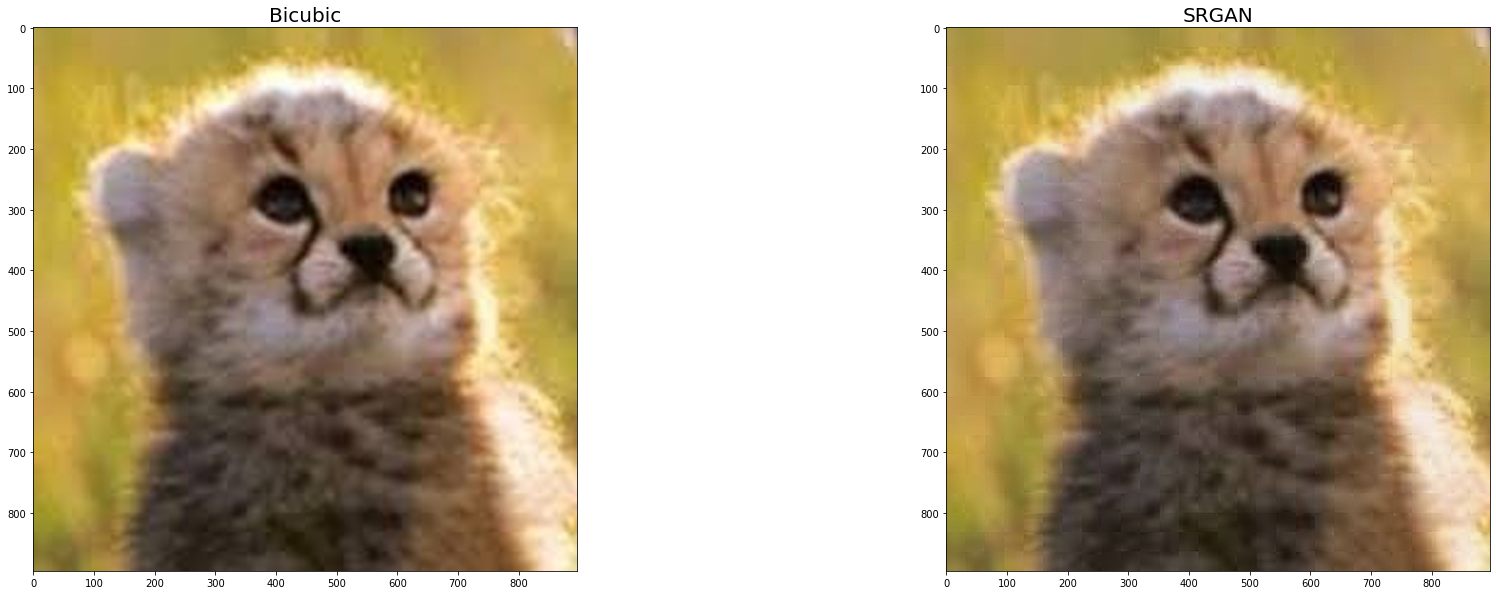

In [13]:
# 시각화를 해봅시다!
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(30,10))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

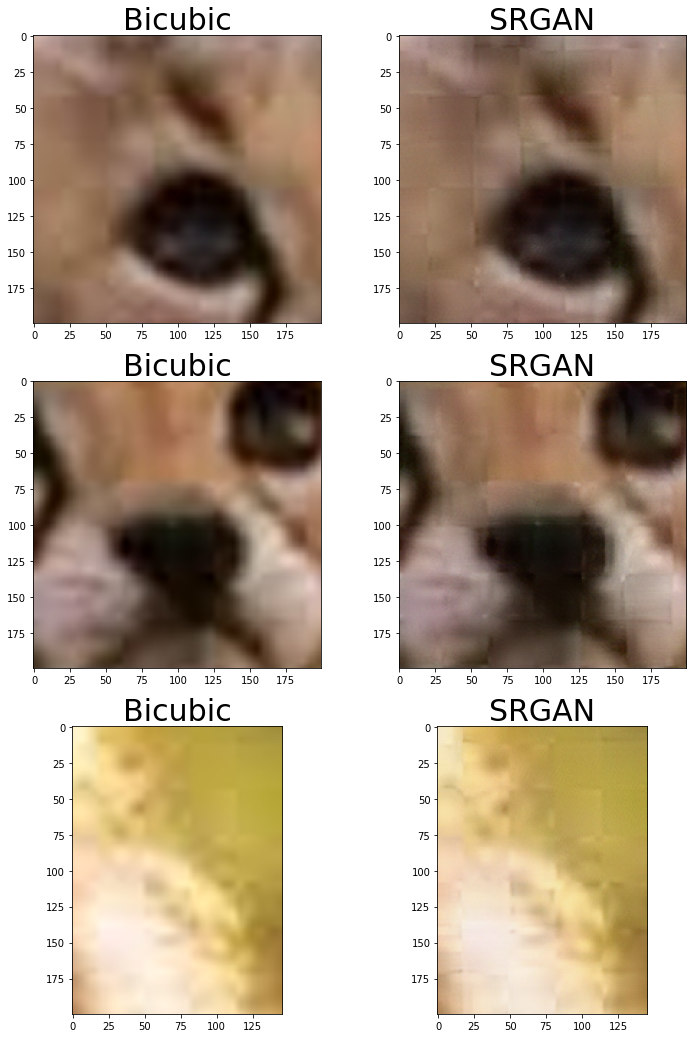

In [14]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(150,300), (250,450), (500,750)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(12,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

## 특이점

- 처음에 SRGAN으로 변환하는 이미지에 고해상도를 넣어봤는데 오류가 떴다 그래서 SRGAN는 고해상도 이미지를 초고해상도로 올릴 수는 없구나를 깨닫게 되었다

- 저해상도 이미지를 찾으니 바로 SRGAN코드가 실행이 되었습니다.

## 프로젝트 2 : SRGAN을 이용해서 고해상도 gif생성하기

#### gif파일 불러오기



In [15]:
! pip install imageio

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
import cv2
import os

gif_path = os.getenv('HOME') + '/aiffel/super_resolution/gif'
gif = cv2.VideoCapture(os.path.join(gif_path, 'fire_lr.gif'))

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 14
frame 크기 : (282, 300, 3)


#### 프레임별 Super Resolution 진행

In [17]:
frames_sr_bicubic = []
for frame in frames:
    frames_sr_bicubic.append(cv2.resize(
        frame, 
        dsize=(frame.shape[1]*4, frame.shape[0]*4), 
        interpolation=cv2.INTER_CUBIC
    ))

In [18]:
frames_sr_srgan = []
for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

### 프레임 합쳐서 gif만들기


In [19]:
import imageio

imageio.mimsave(os.path.join(gif_path, 'fire_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_path, 'fire_hr_srgan.gif'), frames_sr_srgan)

## Jupyter notebook에 gif 표시

- 저해상도 및 고해상도 시각화의 width값 같게 한다

In [20]:
from IPython.display import Image as show_gif

In [ ]:
show_gif(os.path.join(gif_path, 'fire_lr.gif'), width=800)

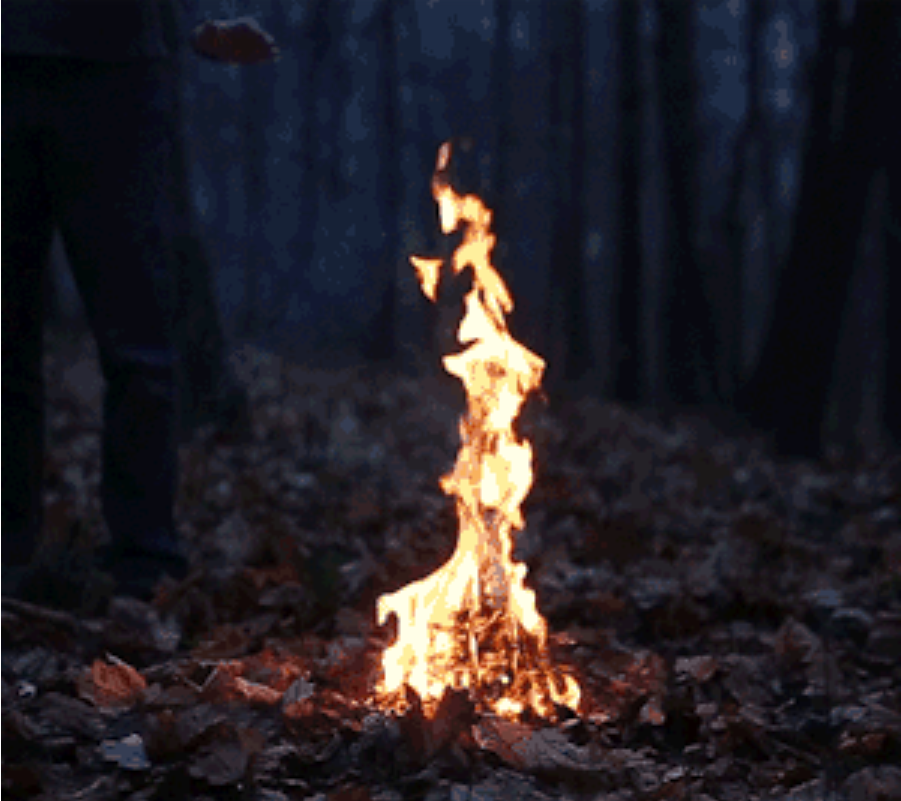

In [ ]:
show_gif(os.path.join(gif_path, 'fire_hr_bicubic.gif'), width=800)

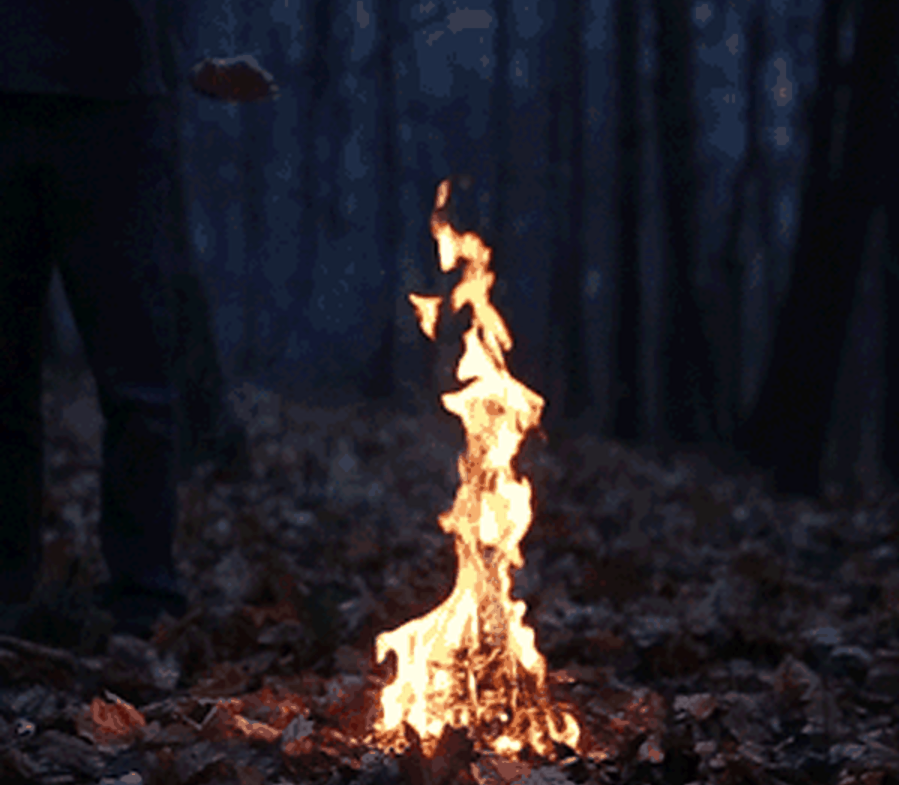


In [ ]:
show_gif(os.path.join(gif_path, 'fire_hr_srgan.gif'), width=800)

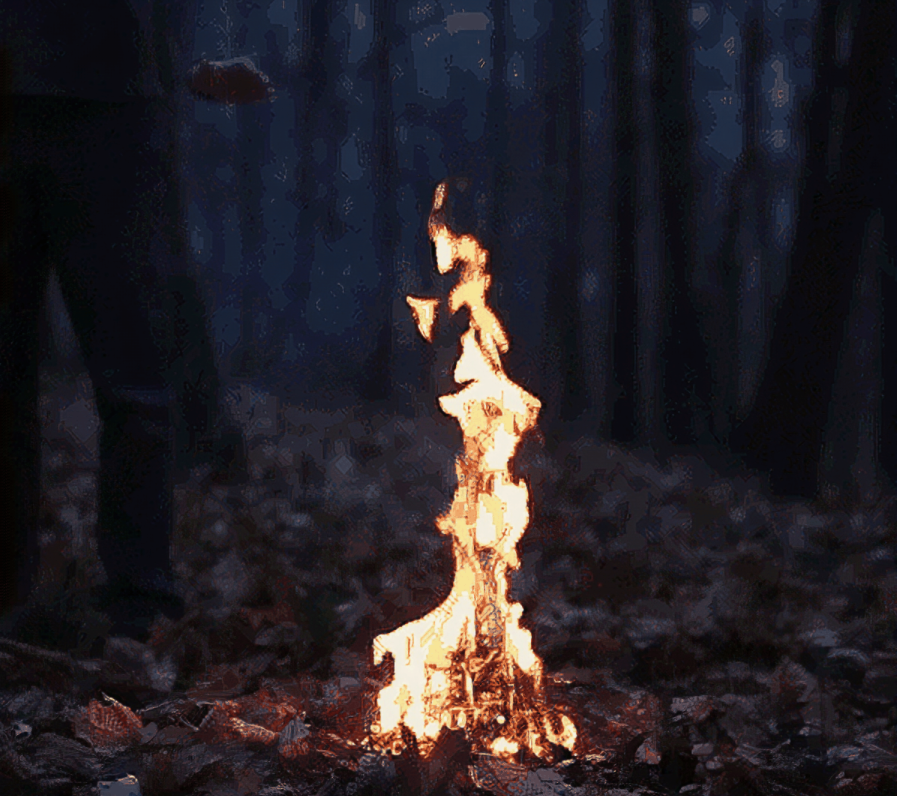

### 프로젝트 회고

- 예전 노드에서 GAN을 가지고 여러 모델링을 해보았지만 크게 와닿거나 실용성에 대해서 의문이 들었습니다. 허나 이번 노드를 통해서 저해상도를 고해상도로 바꿀 수 있는 기술을 알게 되었고 이로 인해 여러 가지 복원기능이 가능하여 현재는 더욱 선명하게 과거 사진을 볼 수 있게 되었습니다. 그 기술에 대해서 배운 것이 좋았습니다. 훗날에 데이터 셋이 저해상도일 때 이 방식을 통해서 고해상도로 바꾸어서 진행해도 될 것 같다는 생각을 하게 되었습니다.